# DIOMIRA

Leaving there and proceeding for three days toward the east, you reach Diomira, a city with sixty silver domes, bronze statues of all the gods, streets paved with lead, a crystal theater, a golden cock that crows every morning on a tower. All these beauties will already be familiar to the visitor, who has seen them also in other cities. But the special quality of this city for the man who arrives there on a September evening, when the days are growing shorter and the multicolored lamps are lighted all at once at the doors of the food stalls and from a terrace a woman's voice cries ooh!, is that he feels envy toward those who now believe they have once before lived an evening identical to this and who think they were happy, that time.

In [70]:
from __future__ import print_function

In [71]:
from IPython.display import Image

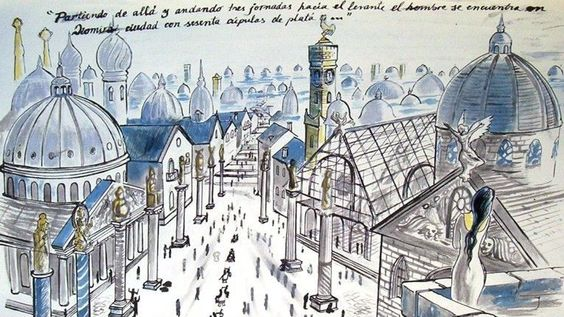

In [72]:
Image(filename='../../../Images/Diomira.jpg') 

In [73]:
import matplotlib
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
import Core.system_of_units as units
import Core.mplFunctions as mpl
import Core.wfmFunctions as wfm
import Core.tblFunctions as tbl
import Sierpe.FEE as FE
from scipy import signal

In [75]:
from Core.coreFunctions import wait

In [76]:
from Database import loadDB

In [77]:
import ICython.Core.system_of_units as SU

In [78]:
import cProfile

In [79]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [8]:
import time

In [9]:
from nose.tools import *

### Diomira NB revisited on:

In [11]:
print(time.strftime("%d/%m/%Y"))

23/11/2016


In [12]:
print(time.strftime("%H:%M:%S"))

16:55:09


## Notes on DIOMIRA

### Role of DIOMIRA

Like all cities in IC, DIOMIRA consumes data to produce some new data. Specifically, DIOMIRA reads an hdf5 file containing MCRD (Monte Carlo Raw Data) for both the energy plane PMTs and the tracking plane SiPMs. 

MCRD represents the true response of sensors (PMTs and SiPMs) in NEXT. Each sensor reacts to the impinging light (primary en EL scintillation) by producing photoelectrons. The true response of the PMTs is described as a train or waveform of single photoelectrons (spe) in time bins of 1 ns. The true response of the SiPMs is described as a train of spes in bins of 1 mus.

The difference in time binning is related with differences in the electronics for PMTs and SiPMs. In the case of PMTs the ouput from the sensor (a current) is passed by the front-end PMT electronics (FEE-PMT) which can be described as the combination of a low-pass filters (LPF) which shapes and amplifies the signals, and a high-pass filter, associated with decoupling capacitor. 

See:
https://github.com/jjgomezcadenas/IC/blob/master/LabTools/DSP_sandbox_VHB.ipynb
https://github.com/jjgomezcadenas/IC/blob/master/Notebooks/SIERPE/SIERPE.ipynb

In the case of the SiPMs, the electronics is simpler (integration each 1 mus). 

The main action of DIOMIRA, then, is to read MCRD waveforms, simulate the response of the energy and tracking plane and produce raw waveforms (RWF) as well as base-line restored waveforms (BRL).

For the energy plane, RWF are the convolution of the MCRD with the LPF and HPF. The resulting function shows a negative swing associated with the differentiation introduced by the HPF. BLR functions are the convolution of the MCRD with the LPF only and correspond to an ideal case in which the RWF can be perfectly deconvoluted (.eg, base line restored). BLR are useful to compare with corrected waveforms (CWF) calculated later in the chain (by ISIDORA), where a real deconvolution algorithm is applied. In both cases, noise and the effect of DAQ is included. 

For the tracking plane, RWF correspond to add a realistic simulation of noise to the SiPMs. 

### Format

1. Diomira saves pmtrwf, sipmrwf and pmtblr wf as Int16, since those arrays correspond to the DAQ output (thus, adc counts). Using Int16 one can express up to 2**16, eg:

In [17]:
2**16

65536

Which is plenty to express the waveforms. 

2. The simulation of the WF is carried out using float64 (pyhton default) but one must convert to int before storing the waveforms. Round errors are negligible compared with both the scale and the noise, but the side effect is that the WF have many zeros which are effectively supressed by the compressor, thus saving space. 

3. If the function is stored as float, the zeros are not exact (e.g, numbers fluctuate around zero without being zero) and the compressor is not effective.

4. The difference in size is up to two orders of magnitude.

5. The simulation of pmtrwf and sipmrwf takes about 3 second/event and about 4.5 second/event adding the PMTBLR.

6. The space in disk is 350 kb/event (without BLR wfm) and 500 kb/event with blr 

### Code

#### PEP

In [13]:
!/Users/jjgomezcadenas/anaconda2/bin/pep8 ../../../Cities/DIOMIRA.py

In [14]:
!/Users/jjgomezcadenas/anaconda2/bin/pyflakes ../../../Cities/DIOMIRA.py

### Running DIOMIRA

In [16]:
ls -lh /Users/jjgomezcadenas/Documents/Development/NEXT/icdata/CalibElectrons/

total 1031240
-rw-r--r--  1 jjgomezcadenas  staff   185M Nov 18 12:54 electrons.1250.0keV.z250mm.next_1000.root.h5
-rw-r--r--  1 jjgomezcadenas  staff   263M Nov 18 12:55 electrons.2500.0keV.z250mm.next_1000.root.h5
-rw-r--r--  1 jjgomezcadenas  staff    56M Nov 18 12:55 electrons.40.0keV.z250mm.next_1000.root.h5


In [17]:
e40 =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/CalibElectrons/electrons.40.0keV.z250mm.next_1000.root.h5','r+')

In [18]:
e40

File(filename=/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/CalibElectrons/electrons.40.0keV.z250mm.next_1000.root.h5, title='', mode='r+', root_uep='/', filters=Filters(complevel=0, shuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/pmtrd (EArray(1000, 12, 800000), zlib(4)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 1, 32768)
/sipmrd (EArray(1000, 1792, 800), zlib(4)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 50, 800)
/Detector (Group) ''
/Detector/DetectorGeometry (Table(1,)) ''
  description := {
  "x_det": Float32Col(shape=(2,), dflt=0.0, pos=0),
  "y_det": Float32Col(shape=(2,), dflt=0.0, pos=1),
  "z_det": Float32Col(shape=(2,), dflt=0.0, pos=2),
  "r_det": Float32Col(shape=(), dflt=0.0, pos=3)}
  byteorder := 'little'
  chunkshape := (2340,)
/MC (Group) ''
/MC/MCTracks (Table(4862,), zl

### Configuration file

In [19]:
ls /Users/jjgomezcadenas/Documents/Development/NEXT/IC/Config

ANASTASIA_default.conf     DOROTHEA_Na.conf
DIOMIRA_NA_ZLIB_test2.csv  DOROTHEA_default.conf
DIOMIRA_default.conf       ISIDORA_default.conf
DIOMIRA_test.csv           filter_example.conf
DOROTHEA_Kr.conf           filter_wrong_blr.conf


In [20]:
less /Users/jjgomezcadenas/Documents/Development/NEXT/IC/Config/DIOMIRA_default.conf

In [22]:
!echo $ICDIR

/Users/jjgomezcadenas/Documents/Development/NEXT/IC


In [33]:
%env ICONF=/Users/jjgomezcadenas/Documents/Development/NEXT/IC/Config/

env: ICONF=/Users/jjgomezcadenas/Documents/Development/NEXT/IC/Config/


In [34]:
!echo $ICDATA

/Users/jjgomezcadenas/Documents/Development/NEXT/icdata


In [35]:
!echo $ICONF

/Users/jjgomezcadenas/Documents/Development/NEXT/IC/Config/


In [36]:
!python ../../../Cities/DIOMIRA.py -c $ICONF/DIOMIRA_default.conf -i \
$ICDATA/CalibElectrons/electrons.40.0keV.z250mm.next_1000.root.h5 \
-o $ICDATA/CalibElectrons/electrons.40.keV.z250_100.RWF.h5 -n 10


Leaving there and proceeding for three days toward the east, you reach Diomira,
a city with sixty silver domes, bronze statues of all the gods, streets paved
with lead, a crystal theater, a golden cock that crows every morning on a
tower. All these beauties will already be familiar to the visitor, who has seen
them also in other cities. But the special quality of this city for the man who
arrives there on a September evening, when the days are growing shorter and the
multicolored lamps are lighted all at once at the doors of the food stalls and
from a terrace a woman's voice cries ooh!, is that he feels envy toward those
who now believe they have once before lived an evening identical to this and
who think they were happy, that time.

COMPRESSION            => ZLIB4
FILE_IN                => /Users/jjgomezcadenas/Documents/Development/NEXT/icdata/CalibElectrons/electrons.40.0keV.z250mm.next_1000.root.h5
FILE_OUT               => /Users/jjgomezcadenas/Documents/Development/NEXT/icdata/

In [37]:
ls -lh /Users/jjgomezcadenas/Documents/Development/NEXT/icdata/CalibElectrons

total 1036848
-rw-r--r--  1 jjgomezcadenas  staff   185M Nov 18 12:54 electrons.1250.0keV.z250mm.next_1000.root.h5
-rw-r--r--  1 jjgomezcadenas  staff   263M Nov 18 12:55 electrons.2500.0keV.z250mm.next_1000.root.h5
-rw-r--r--  1 jjgomezcadenas  staff    56M Nov 18 12:55 electrons.40.0keV.z250mm.next_1000.root.h5
-rw-r--r--  1 jjgomezcadenas  staff   2.7M Nov 23 17:22 electrons.40.keV.z250_100.RWF.h5


In [41]:
e40rwf =tables.open_file("/Users/jjgomezcadenas/Documents/Development/NEXT/icdata//CalibElectrons/electrons.40.keV.z250_100.RWF.h5",'r+')

In [42]:
e40rwf

File(filename=/Users/jjgomezcadenas/Documents/Development/NEXT/icdata//CalibElectrons/electrons.40.keV.z250_100.RWF.h5, title='', mode='r+', root_uep='/', filters=Filters(complevel=4, complib='zlib', shuffle=True, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/MC (Group) ''
/MC/FEE (Table(1,)) 'EP-FEE parameters'
  description := {
  "OFFSET": Int16Col(shape=(), dflt=0, pos=0),
  "CEILING": Int16Col(shape=(), dflt=0, pos=1),
  "PMT_GAIN": Float32Col(shape=(), dflt=0.0, pos=2),
  "FEE_GAIN": Float32Col(shape=(), dflt=0.0, pos=3),
  "R1": Float32Col(shape=(), dflt=0.0, pos=4),
  "C1": Float32Col(shape=(), dflt=0.0, pos=5),
  "C2": Float32Col(shape=(), dflt=0.0, pos=6),
  "ZIN": Float32Col(shape=(), dflt=0.0, pos=7),
  "DAQ_GAIN": Float32Col(shape=(), dflt=0.0, pos=8),
  "NBITS": Float32Col(shape=(), dflt=0.0, pos=9),
  "LSB": Float32Col(shape=(), dflt=0.0, pos=10),
  "NOISE_I": Float32Col(shape=(), dflt=0.0, pos=11),
  "NOISE_DAQ": Float32Col(shape=(), dflt=0.0, pos=1

In [43]:
DataPMT = loadDB.DataPMT()

In [44]:
DataPMT

,SensorID,ChannelID,PmtID,Active,X,Y,coeff_c,coeff_blr,adc_to_pes,noise_rms,sigma
0,0,0,1,1,-23.9414,65.7785,0.000003,0.001632,-24.3395,0.7060,7.73100
1,1,18,3,1,-44.9951,-53.6231,0.000003,0.001632,-24.8580,0.8744,8.82000
2,2,1,2,1,68.9365,-12.1554,0.000003,0.001611,-26.2934,0.7213,8.01375
3,3,19,4,1,0.0000,185.0000,0.000003,0.001599,-26.4110,0.7624,8.42224
4,4,27,C,1,-118.9160,141.7180,0.000003,0.001567,-26.7098,0.7921,6.23125
5,5,26,B,1,-182.1890,32.1249,0.000004,0.001650,-22.4456,0.8660,5.65180
6,6,9,A,1,-160.2150,-92.5000,0.000003,0.001593,-23.3552,0.7062,7.37840
7,7,8,9,1,-63.2737,-173.8430,0.000003,0.001612,-33.8821,0.7278,11.94840
8,8,23,8,1,63.2737,-173.8430,0.000003,0.001601,-21.8220,0.7303,6.11073
9,9,22,7,1,160.2150,-92.5000,0.000003,0.001593,-25.8020,0.7160,7.46200


### Checking pmtrwf and pmtblr

In [53]:
pmttwf, pmtrwf, pmtblr = tbl.get_pmt_vectors(e40rwf)

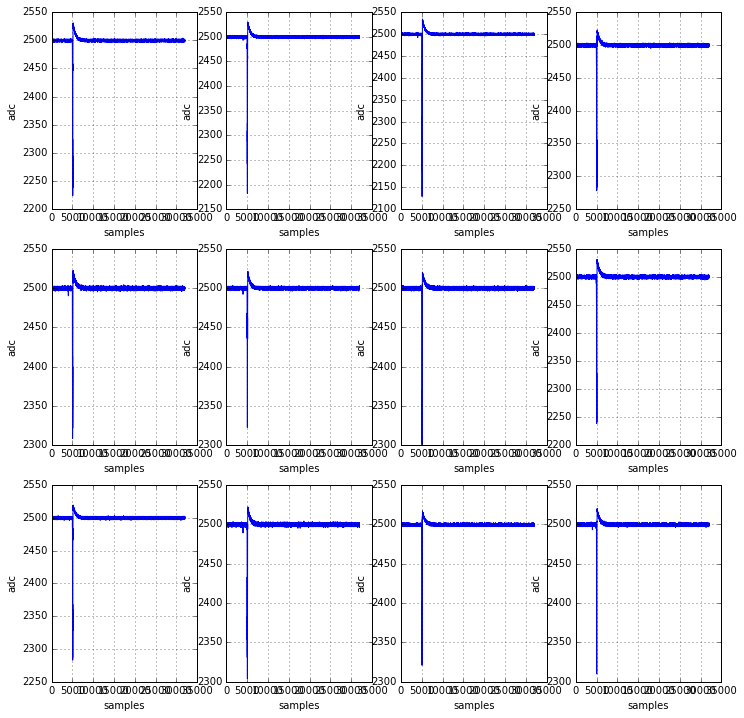

In [54]:
mpl.plot_waveforms(pmtrwf[0], maxlen=0, zoom=False, window_size=800)

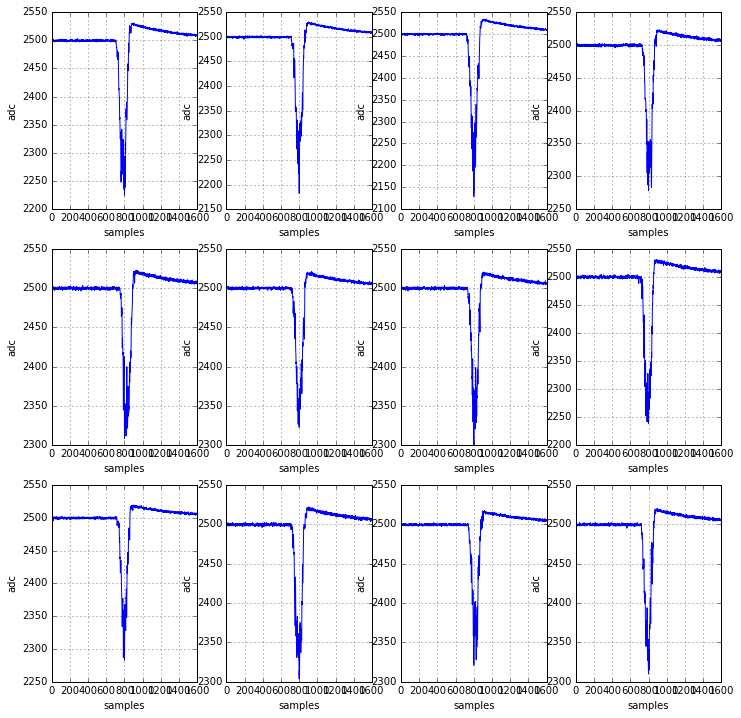

In [55]:
mpl.plot_waveforms(pmtrwf[0], maxlen=0, zoom=True, window_size=800)

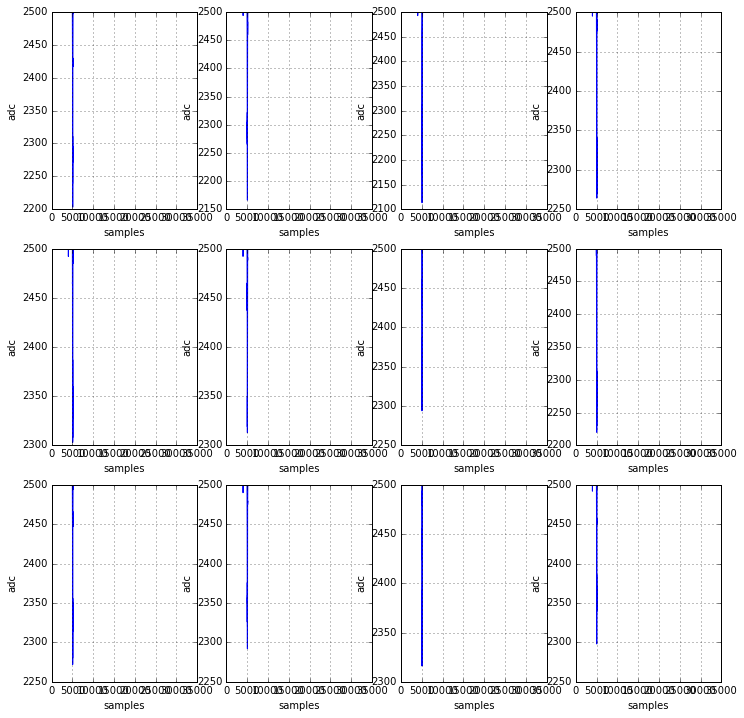

In [56]:
mpl.plot_waveforms(pmtblr[0], maxlen=0, zoom=False, window_size=800)

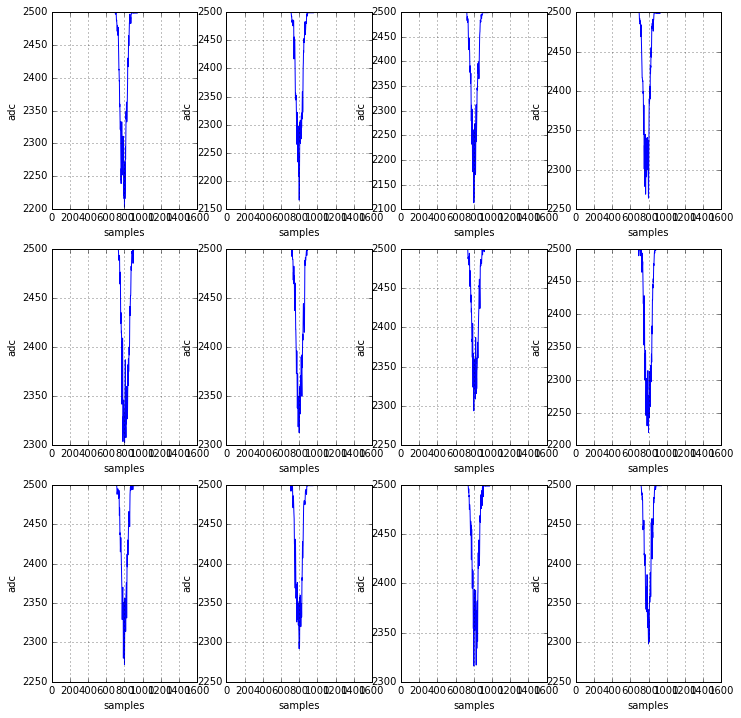

In [57]:
mpl.plot_waveforms(pmtblr[0], maxlen=0, zoom=True, window_size=800)

In [65]:
def get_energy_blr(pmtea, event_list=[0]):
    """
    Compute the sum of the waveforms for some events.

    Parameters
    ----------
    pmtea : tb.EArray
        The waveform (axis 2) for each sensor (axis 1) and event (axis 0).
    event_list : sequence of ints
        Event numbers.

    Returns
    -------
    wfes : pd.DataFrame
        Contains the sum of the waveform for each sensor indexed by ID.
    """
    NPMT = pmtea.shape[1]
    EPMT = []

    for i in event_list:
        epmt = np.zeros(NPMT)
        for j in range(NPMT):
            epmt[j] = np.sum(FE.OFFSET - pmtea[i, j])
        EPMT.append(epmt/FE.ADC_TO_PES)

    return pd.DataFrame(EPMT)

In [66]:
ene_blr = get_energy_blr(pmtblr, event_list=range(10))

In [67]:
ene_blr

,0,1,2,3,4,5,6,7,8,9,10,11
0,922.857143,908.268398,1051.904762,705.541126,672.380952,594.285714,605.800866,898.441558,583.290043,654.242424,518.614719,596.017316
1,957.835498,977.099567,1022.987013,677.575758,747.878788,645.670996,614.285714,843.982684,569.567100,671.212121,524.458874,570.173160
2,945.714286,964.761905,1029.480519,703.593074,691.948052,597.142857,630.562771,980.346320,576.926407,662.380952,515.238095,543.852814
3,892.077922,921.255411,953.939394,735.411255,713.203463,569.393939,618.528139,922.554113,570.692641,653.290043,509.826840,579.610390
4,921.385281,955.021645,994.761905,697.445887,704.805195,553.939394,571.125541,828.917749,598.614719,660.822511,507.056277,558.051948
5,937.575758,989.826840,1040.995671,681.255411,697.186147,586.233766,611.255411,932.727273,555.367965,635.454545,532.034632,581.125541
6,930.649351,929.610390,1027.878788,690.043290,677.922078,626.796537,602.034632,849.696970,579.090909,650.129870,528.354978,583.030303
7,854.025974,909.696970,971.515152,683.593074,651.948052,562.337662,572.207792,911.774892,602.640693,664.545455,523.333333,561.212121
8,962.207792,919.220779,989.177489,617.965368,681.038961,585.194805,583.593074,890.995671,536.580087,692.467532,497.748918,596.060606
9,894.242424,930.000000,1032.251082,711.904762,727.705628,631.818182,610.822511,863.506494,580.822511,705.497835,524.155844,576.536797


In [146]:
%%cython
"""
Classes and functions describing the electronics of the
PMT plane FEE.
(full model)
VH, JJGC, November, 2016
"""
import numpy as np
cimport numpy as np
from scipy import signal
import Database.loadDB as DB
import ICython.Core.system_of_units as SU

cdef class FEEGlobals:
    cdef readonly double PMT_GAIN, x_slope, x_flat, FEE_GAIN, DAQ_GAIN, LSB, NOISE_I
    cdef readonly NOISE_DAQ, C2, C1, R1, Zin, t_sample, time_step, f_sample, f_mc 
    cdef readonly f_LPF1, f_LPF2, ADC_TO_PES_LPF, ADC_TO_PES 
    cdef readonly int NBITS, OFFSET, CEILING 
    
    def __init__(self):
        units = SU.SystemOfUnits()

        self.PMT_GAIN = 1.7e6
        self.x_slope=5.*units.ns
        self.x_flat=1.*units.ns
        self.FEE_GAIN = 582.237*units.ohm
        self.DAQ_GAIN = 1.25
        self.NBITS = 12
        self.LSB = 2.0*units.V/2**self.NBITS/self.DAQ_GAIN
        self.NOISE_I = self.LSB/(self.FEE_GAIN*self.DAQ_GAIN)
        self.NOISE_DAQ = 0.313*units.mV

        self.C2 = 8*units.nF
        self.C1 = 2714*units.nF
        self.R1 = 1567*units.ohm
        self.Zin = 62*units.ohm
        self.t_sample = 25*units.ns
        self.f_sample = 1./self.t_sample
        self.time_step = 1.*units.ns
        self.f_mc = 1./self.time_step
        self.f_LPF1 = 3*units.MHZ
        self.f_LPF2 = 10*units.MHZ
        self.ADC_TO_PES_LPF = 24.1  # After LPF, comes out from spe area
        self.ADC_TO_PES = 23.1
        self.OFFSET = 2500  # offset adc
        self.CEILING = 4096  # ceiling of adc

    cpdef double i_to_adc(self):
        """
        current to adc counts
        """
        return self.FEE_GAIN/self.LSB


    cpdef double i_to_v(self):
        """
        current to voltage
        """
        return self.FEE_GAIN


    cpdef double v_to_adc(self):
        """
        voltage to adc
        """
        return 1./self.LSB

    
cdef class SPE:
    """
    Represents a single photo-electron in the PMT
    """
    
    cdef double A
    def __init__(self):
        self.A = 0
                
    
    cpdef np.ndarray[np.float64_t, ndim=1] spe(self):
        """
        single photoelectron pulse
        """
        fee = FEEGlobals()
        units = SU.SystemOfUnits()
        cdef double spe_base = fee.x_slope + fee.x_flat
        self.A = fee.PMT_GAIN*units.eplus/spe_base
        cdef int nns = int(fee.x_slope/fee.time_step)
        cdef int nnf = int(fee.x_flat/fee.time_step)
 
        cdef np.ndarray[np.float64_t, ndim=1] rise = np.linspace(0, self.A, num=nns)
        cdef np.ndarray[np.float64_t, ndim=1] fall = np.linspace(self.A, 0, num=nns)
        cdef np.ndarray[np.float64_t, ndim=1] flat = self.A*np.ones(nnf)
        
        return np.concatenate((rise, flat, fall))
    
    cpdef np.ndarray[np.float64_t, ndim=1] spe_pulse(self, float t0, float tmax, float time_step):
        """
    
        Returns a SPE pulse at time t0
        with baseline extending in steps of time_step from 0 to tmax
        determined by DELTA_L
        """
        cdef int n = int(t0/time_step)
        cdef int nmax = int(tmax/time_step)

        cdef  np.ndarray[np.float64_t, ndim=1] DELTA = np.zeros(nmax)   # Dirac delta of size DELTA_L
        DELTA[n] = 1
    
        cdef  np.ndarray[np.float64_t, ndim=1] spe_pulse = signal.convolve(DELTA, self.spe())

        return spe_pulse
    
    cpdef np.ndarray[np.float64_t, ndim=1] spe_pulse_train(self,
                                                           signal_start,
                                                           signal_length, 
                                                           daq_window,
                                                           time_step):
        """
        Returns a train of SPE pulses between signal_start
        and start+length in daq_window separated by tstep
        """
        cdef int nmin = int(signal_start/time_step)
        cdef int nmax = int((signal_start + signal_length)/time_step)
        cdef int NMAX = int(daq_window/time_step)
    
        cdef  np.ndarray[np.float64_t, ndim=1] DELTA = np.zeros(NMAX)
        DELTA[nmin:nmax+1] = 1.
    
        cdef np.ndarray[np.float64_t, ndim=1] spe_pulse = signal.convolve(DELTA, self.spe())

        return spe_pulse
    
    cpdef np.ndarray[np.float64_t, ndim=1] spe_pulse_from_ivector(self, np.ndarray[np.int64_t, ndim=1] cnt):
        """
        Returns a train of SPE pulses corresponding to vector cnt
        """

        return signal.convolve(cnt[0:-len(self.spe())+1], self.spe())
    
    cpdef np.ndarray[np.float64_t, ndim=1] spe_pulse_from_fvector(self, np.ndarray[np.float64_t, ndim=1] cnt):
        """
        Returns a train of SPE pulses corresponding to vector cnt
        """

        return signal.convolve(cnt[0:-len(self.spe())+1], self.spe())
   



In [92]:
feg = FEEGlobals()

In [93]:
feg.i_to_v()

9.328469220872098e-14

In [94]:
units = SU.SystemOfUnits()

In [95]:
feg.i_to_v()/units.mV

9.328469220872098e-05

In [147]:
cspe = SPE()

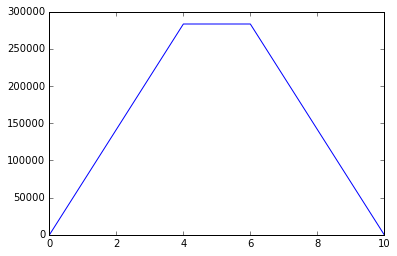

In [137]:
plt.plot(cspe.spe())

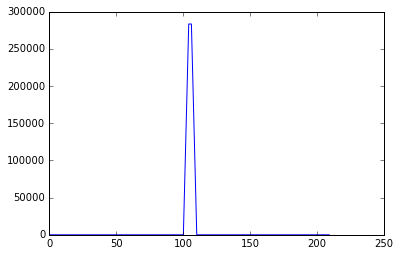

In [138]:
plt.plot(cspe.spe_pulse(t0=100*units.ns, tmax=200*units.ns,
              time_step=1*units.ns))

In [113]:
spe = FE.SPE()

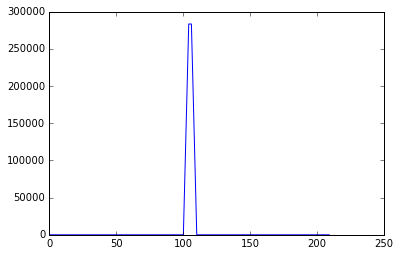

In [115]:
plt.plot(FE.spe_pulse(spe,t0=100*units.ns, tmax=200*units.ns,
              time_step=1*units.ns))

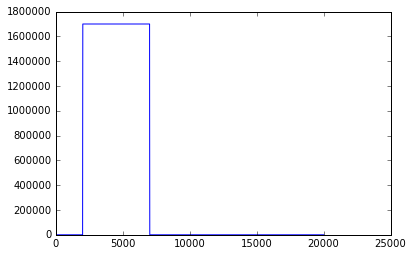

In [122]:
plt.plot(FE.spe_pulse_train(spe,
                    signal_start=2000*units.ns,
                    signal_length=5000*units.ns, daq_window=20*units.mus,
                    time_step=1*units.ns))

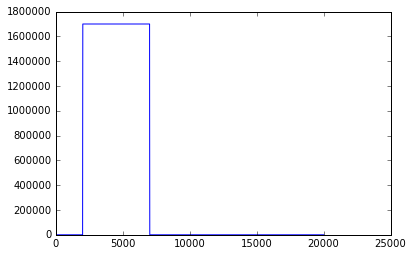

In [139]:
plt.plot(cspe.spe_pulse_train(signal_start=2000*units.ns,
                    signal_length=5000*units.ns, daq_window=20*units.mus,
                    time_step=1*units.ns))

In [132]:
cnt = np.random.poisson(5, 10000)

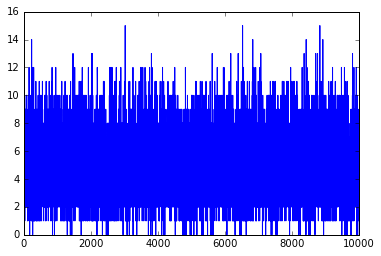

In [133]:
plt.plot(cnt)

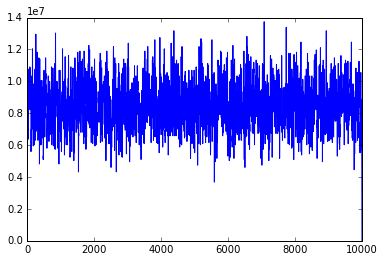

In [135]:
plt.plot(FE.spe_pulse_from_vector(spe, cnt))

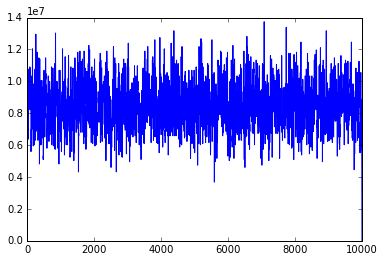

In [148]:
plt.plot(FE.spe_pulse_from_vector(spe, cnt))

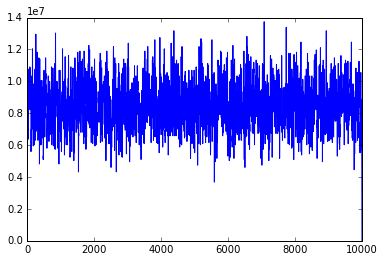

In [149]:
plt.plot(cspe.spe_pulse_from_ivector(cnt))

In [150]:
5.9*2.3

13.57

In [151]:
1.9*13.57/20.

1.2891499999999998